### Download movie review dataset from Kaggle

In [1]:
# Download kaggle dataset
# !kaggle competitions download -c sentiment-analysis-on-movie-reviews
# !unzip sentiment-analysis-on-movie-reviews.zip
# !unzip train.tsv.zip
# !unzip test.tsv.zip

In [ ]:
from dotenv import load_dotenv

load_dotenv()

import os

api_key = os.getenv("HF_KEY")

### Import libraries and convert train/test data to pandas dataframe

In [8]:
import pandas as pd
import random
import json

In [9]:
# Read "train.tsv" and "test.tsv" and as a pandas dataframe for training and validation
df_train_val = pd.read_table(r"train.tsv")
df_test = pd.read_table(r"test.tsv")

In [10]:
# Create a new column in the training and validation dataframe to represent the number of words in every phrase
df_train_val['num_words'] = df_train_val.Phrase.str.split().apply(lambda x: len(x))
df_test['num_words'] = df_test.Phrase.str.split().apply(lambda x: len(x))

In [11]:
# Create 80/20 train and validation split for data provided in "train.tsv"
# All the data provided in "test.csv" will be used for kaggle model testing
df_train_val['TrainValTest'] = random.choices(['Train', 'Validate'], weights=(0.8, 0.2), k=len(df_train_val))
df_test['TrainValTest'] = 'Test'
df = pd.concat([df_train_val, df_test])
df.head()

,PhraseId,SentenceId,Phrase,Sentiment,num_words,TrainValTest
0,1,1,A series of escapades demonstrating the adage ...,1.0,37,Train
1,2,1,A series of escapades demonstrating the adage ...,2.0,14,Train
2,3,1,A series,2.0,2,Train
3,4,1,A,2.0,1,Train
4,5,1,series,2.0,1,Train


In [13]:
# Convert the data to a dictionary format
data_dict = df.to_dict(orient="records")

In [15]:
# Save data_dict as a json line file to save movie review data in HuggingFace datasets
with open("train.jsonl", "w") as f:
    for line in data_dict:
        f.write(json.dumps(line) + "\n")

##### JSONL file saved from the previous code block was uploaded to create HugginFace dataset

### Connect to HugginFace

In [1]:
access_token = api_key

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [36]:
# Load movie review data from HugginFace dataset

from datasets import load_dataset
from datasets import ClassLabel, Value

mr_dataset = load_dataset("sasingh192/movie-review", split='train')
mr_dataset = mr_dataset.rename_column("Sentiment", "labels")

Found cached dataset json (/home/ssingh192/.cache/huggingface/datasets/sasingh192___json/sasingh192--movie-review-620bdb176a75fc19/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


In [256]:
features = mr_dataset.features
features

{'PhraseId': Value(dtype='int64', id=None),
 'SentenceId': Value(dtype='int64', id=None),
 'Phrase': Value(dtype='string', id=None),
 'labels': Value(dtype='float64', id=None),
 'num_words': Value(dtype='int64', id=None),
 'TrainValTest': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [48]:
# Create index to label dictionary which will be used as an argument for model defination
labels = ['negative', 'somewhat negative', 'neutral', 'somewhat positive', 'positive']
id2label = {idx: labels[idx] for idx in range(5)}
id2label

{0: 'negative',
 1: 'somewhat negative',
 2: 'neutral',
 3: 'somewhat positive',
 4: 'positive'}

In [49]:
# Create label to index dictionary which will be used as an argument for model defination
label2id = {v:k for k,v in id2label.items()}
label2id

{'negative': 0,
 'somewhat negative': 1,
 'neutral': 2,
 'somewhat positive': 3,
 'positive': 4}

In [52]:
# Data shown below reveal that we are dealing with an imbalanced dataset
df = mr_dataset.to_pandas()
df.labels.value_counts(normalize=True).sort_index()

0.0    0.045316
1.0    0.174760
2.0    0.509945
3.0    0.210989
4.0    0.058990
Name: labels, dtype: float64

There is a class imbalance shown above. Upsampling the rare class does not work very well with Transformers. The model will not generalize very well for the data from the rare class. 

A better way to handle this class imbalance is to modify the loss function for the training.

## Tokenize all the things

In [54]:
from transformers import AutoTokenizer

model_ckpt = "microsoft/miniLM-L12-H384-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [55]:
tokenizer(mr_dataset["Phrase"][0])

{'input_ids': [101, 1037, 2186, 1997, 9686, 17695, 18673, 14313, 1996, 15262, 3351, 2008, 2054, 2003, 2204, 2005, 1996, 13020, 2003, 2036, 2204, 2005, 1996, 25957, 4063, 1010, 2070, 1997, 2029, 5681, 2572, 25581, 2021, 3904, 1997, 2029, 8310, 2000, 2172, 1997, 1037, 2466, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [56]:
def tokenize_text(examples):
    return tokenizer(examples["Phrase"], truncation=True, max_length=512)

In [57]:
mr_dataset = mr_dataset.map(tokenize_text, batched=True)
mr_dataset

Map:   0%|          | 0/222352 [00:00<?, ? examples/s]

Dataset({
    features: ['PhraseId', 'SentenceId', 'Phrase', 'labels', 'num_words', 'TrainValTest', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 222352
})

## Dealing with imbalanced classes

In [209]:
class_weights = (1 - (df["labels"].value_counts().sort_index() / len(df))).values
class_weights

array([0.96819457, 0.87734313, 0.64209002, 0.85191498, 0.95859718])

In [210]:
from torch import nn
import torch
from transformers import Trainer

class_weights = torch.from_numpy(class_weights).float().to("cuda")
class_weights

tensor([0.9682, 0.8773, 0.6421, 0.8519, 0.9586], device='cuda:0')

In [211]:
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        #Feed inputs to the model and extract logits
        outputs = model(**inputs)
        logits = outputs.get("logits")
        #Extract labels
        labels = inputs.get("labels")
        #Define loss function with class weights
        loss_func = nn.CrossEntropyLoss(weight=class_weights)
        #Compute loss
        loss = loss_func(logits, labels)
        return (loss, outputs) if return_outputs else loss

## Putting it all together

In [212]:
from datasets import Features, Value

In [213]:
# labels column is float dtype and it needs to be converted to int dtype to make it work with HF model. This needs to be perfomed for both train and validation dataset
new_features = train_dataset.features.copy()
new_features['labels'] = Value('int64')

train_dataset = mr_dataset.filter(lambda example: example['TrainValTest']=='Train')
train_dataset = train_dataset.cast(new_features)
train_dataset.features

val_dataset = mr_dataset.filter(lambda example: example['TrainValTest']=='Validate')
val_dataset = train_dataset.cast(new_features)
val_dataset.features

Loading cached processed dataset at /home/ssingh192/.cache/huggingface/datasets/sasingh192___json/sasingh192--movie-review-620bdb176a75fc19/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-87813bd77ea8c143.arrow
Loading cached processed dataset at /home/ssingh192/.cache/huggingface/datasets/sasingh192___json/sasingh192--movie-review-620bdb176a75fc19/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-5d42542c94ac6d01.arrow
Loading cached processed dataset at /home/ssingh192/.cache/huggingface/datasets/sasingh192___json/sasingh192--movie-review-620bdb176a75fc19/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-33c6e5cb4c88031f.arrow
Loading cached processed dataset at /home/ssingh192/.cache/huggingface/datasets/sasingh192___json/sasingh192--movie-review-620bdb176a75fc19/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-f484ce022e4c6076.arrow


{'PhraseId': Value(dtype='int64', id=None),
 'SentenceId': Value(dtype='int64', id=None),
 'Phrase': Value(dtype='string', id=None),
 'labels': Value(dtype='int64', id=None),
 'num_words': Value(dtype='int64', id=None),
 'TrainValTest': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [214]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
cuda.empty_cache()
print(device)

cuda


In [215]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                           num_labels=5,
                                                           id2label=id2label,
                                                           label2id=label2id)

model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/miniLM-L12-H384-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12,

In [219]:
# f1 metric will be used to qunatify the performance of classification model
from sklearn.metrics import f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    return {"f1": f1}

In [220]:
from transformers import TrainingArguments

batch_size = 64
# Log the training loss at each step
logging_steps = len(train_dataset) // batch_size

output_dir = "minilm-finetuned-movie"

training_args = TrainingArguments(output_dir=output_dir,
                                  num_train_epochs=50,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  logging_steps=logging_steps,
                                  fp16=True, # Make it train fast
                                  push_to_hub=True)

In [221]:
trainer = WeightedLossTrainer(model=model,
                              args=training_args,
                              compute_metrics=compute_metrics,
                              train_dataset=train_dataset,
                              eval_dataset=val_dataset,
                              tokenizer=tokenizer)

Cloning https://huggingface.co/sasingh192/minilm-finetuned-movie into local empty directory.


In [222]:
trainer.train()

/home/ssingh192/anaconda3/envs/torchml/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.962300,0.774155,0.698455
2,0.796900,0.728949,0.709444
3,0.740000,0.647873,0.747621
4,0.701200,0.626322,0.754973
5,0.668900,0.582270,0.776191
6,0.641600,0.579645,0.767312
7,0.614900,0.532368,0.791173
8,0.593900,0.518883,0.798580
9,0.571400,0.479310,0.818379
10,0.549500,0.456614,0.824905


TrainOutput(global_step=97300, training_loss=0.3607479418267449, metrics={'train_runtime': 9317.4298, 'train_samples_per_second': 668.14, 'train_steps_per_second': 10.443, 'total_flos': 3.329335200564821e+16, 'train_loss': 0.3607479418267449, 'epoch': 50.0})

<Axes: xlabel='epoch'>

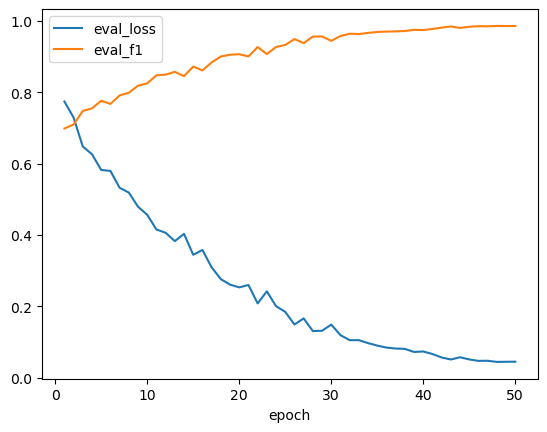

In [277]:
# df_out is the dataframe with loss and f1 scores of the trained model on evaluation dataset
# Plot eval_loss and f1
df_out = pd.DataFrame(trainer.state.log_history)
df_out[['epoch', 'eval_loss', 'eval_f1']].dropna().plot(x='epoch')

In [223]:
predictions = trainer.predict(val_dataset)
print(predictions.predictions.shape, predictions.label_ids.shape)

(124507, 5) (124507,)


In [278]:
import numpy as np
from datasets import load_metric

# metric = load_metric("glue", "mrpc")
metric1 = load_metric("precision")
metric2 = load_metric("recall")
metric3 = load_metric("f1")
preds = np.argmax(predictions.predictions, axis=-1)
print(metric1.compute(predictions=preds, references=predictions.label_ids, average="weighted"))
print(metric2.compute(predictions=preds, references=predictions.label_ids, average="weighted"))
print(metric3.compute(predictions=preds, references=predictions.label_ids, average="weighted"))

{'precision': 0.9859446515147431}
{'recall': 0.9855349498421776}
{'f1': 0.9856171292570882}


In [294]:
y = predictions.label_ids
yhat = predictions.predictions.argmax(axis=-1)

In [297]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y, yhat)

array([[ 5614,     8,     2,     0,     0],
       [  219, 21516,    53,     2,     0],
       [  103,   289, 62599,   506,    44],
       [    0,     5,    65, 25605,   496],
       [    0,     0,     0,     9,  7372]])

In [296]:
from sklearn.metrics import classification_report
print(classification_report(y, yhat))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5624
           1       0.99      0.99      0.99     21790
           2       1.00      0.99      0.99     63541
           3       0.98      0.98      0.98     26171
           4       0.93      1.00      0.96      7381

    accuracy                           0.99    124507
   macro avg       0.97      0.99      0.98    124507
weighted avg       0.99      0.99      0.99    124507



### Using the fine-tuned model

In [5]:
from transformers import pipeline

model_ckpt_fine_tuned = "sasingh192/minilm-finetuned-movie"
pipe = pipeline("text-classification", model=model_ckpt_fine_tuned)

In [6]:
print(pipe("This is the best action movie I have ever seen"))
print(pipe("My wife enjoyed the suspense in this movie"))
print(pipe("I found this movie to be slow in the beginning, but in the end it had rather become captivating"))
print(pipe("I think that it was a waste of money"))

[{'label': 'positive', 'score': 0.9904560446739197}]
[{'label': 'somewhat positive', 'score': 0.8979518413543701}]
[{'label': 'neutral', 'score': 0.9861407279968262}]
[{'label': 'somewhat negative', 'score': 0.998238205909729}]


In [8]:
import torch
torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060'

### Blind test data set

In [405]:
test_dataset = mr_dataset.filter(lambda example: example['TrainValTest']=='Test')
test_dataset.features
df_test = test_dataset.to_pandas()

Loading cached processed dataset at /home/ssingh192/.cache/huggingface/datasets/sasingh192___json/sasingh192--movie-review-620bdb176a75fc19/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-57ada20153d86957.arrow


In [376]:
test_predictions = pipe(test_dataset['Phrase'])

In [406]:
# label2id[test_predictions[0]['label']]
df_test['Sentiment'] = [label2id[elem['label']] for elem in test_predictions]

In [411]:
df_results = df_test[['PhraseId', 'Sentiment']]
df_results.to_csv('Submission.csv', index=False)